In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import torchvision
from torchvision.transforms import v2 as tt
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [2]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()

def RMSE(output, labels):
    return torch.sqrt(torch.mean((output - labels) ** 2)).item()

def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    verbose=True,
    eval_metrics=[accuracy],
    label_idx=-1,
):

    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]

    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
    }
    for eval_metric_name in eval_metric_names:
        history["train"][eval_metric_name] = []
        history["valid"][eval_metric_name] = []

    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = {eval_metric_name: 0 for eval_metric_name in eval_metric_names}
        total = 0
        evaluation_train = {
            "loss": 0,
            **{eval_metric_name: 0 for eval_metric_name in eval_metric_names},
        }

        for idx, data in enumerate(tqdm(train_loader, disable=not verbose)):
            input, labels = data[0].to(device), data[label_idx].to(device)
            # print(input.shape, labels.shape)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                correct[eval_metric_name] += torch.tensor(
                    eval_metric(output, labels)
                ).item() * len(labels)
            total += len(labels)

        for eval_metric_name in eval_metric_names:
            evaluation_train[eval_metric_name] = correct[eval_metric_name] / total

        evaluation_train["loss"] = Loss_epoch / total
        evaluation_valid, *_ = evaluate(
            model,
            valid_loader,
            criterion,
            device,
            eval_metrics=eval_metrics,
            label_idx=label_idx,
        )
        if verbose:
            print(
                f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}"
            )

        for eval_metric_name in eval_metric_names:
            history["train"][eval_metric_name].append(
                evaluation_train[eval_metric_name]
            )
            history["valid"][eval_metric_name].append(
                evaluation_valid[eval_metric_name]
            )

        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])

    return history


def evaluate(
    model,
    data_loader,
    criterion,
    device,
    eval_metrics=[accuracy],
    return_preds=False,
    return_features=False,
    label_idx=-1,
):
    model.eval()
    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]
    metrics = {eval_metric_name: [] for eval_metric_name in eval_metric_names}
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[label_idx].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target.float())

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                metrics[eval_metric_name].append(eval_metric(output, target))

            Loss_history.append(loss.item())
            if return_preds:

                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return (
        {
            **{
                eval_metric_name: torch.mean(
                    torch.Tensor(metrics[eval_metric_name])
                ).item()
                for eval_metric_name in eval_metric_names
            },
            "loss": torch.mean(torch.Tensor(Loss_history)).item(),
        },
        PREDS,
        features,
        ground_truth,
    )

In [3]:
# Define the base directory where images and ground truth data are stored

# Define the subdirectories for images and ground truth
import os


train_images = "./ISIC/train/"
train_masks = "./ISIC/train_masks/"
test_images = "./ISIC/test/"
test_masks = "./ISIC/test_masks/"
# Combine the base directory with subdirectories

# Get paths to the training and target images
train_image_paths = sorted(
    [
        os.path.join(train_images, fname)
        for fname in os.listdir(train_images)
        if fname.endswith(".jpg")
    ]
)
train_masks_paths = sorted(
    [
        os.path.join(train_masks, fname)
        for fname in os.listdir(train_masks)
        if fname.endswith(".png")
    ]
)


# Split your data into training, validation, and test sets
train_image_paths, val_image_paths, train_masks_paths, val_masks_paths = (
    train_test_split(
        train_image_paths, train_masks_paths, test_size=0.2, random_state=32
    )
)


test_image_paths = sorted(
    [
        os.path.join(test_images, fname)
        for fname in os.listdir(test_images)
        if fname.endswith(".jpg")
    ]
)
test_masks_paths = sorted(
    [
        os.path.join(test_masks, fname)
        for fname in os.listdir(test_masks)
        if fname.endswith(".png")
    ]
)

# Check if dimensions are equal
print("Number of samples in the train image folder:", len(train_image_paths))
print("Number of samples in the train  mask folder:", len(train_masks_paths))
print("Number of samples in the test image folder:", len(test_image_paths))
print("Number of samples in the test mask folder:", len(test_masks_paths))

Number of samples in the train image folder: 720
Number of samples in the train  mask folder: 720
Number of samples in the test image folder: 379
Number of samples in the test mask folder: 379


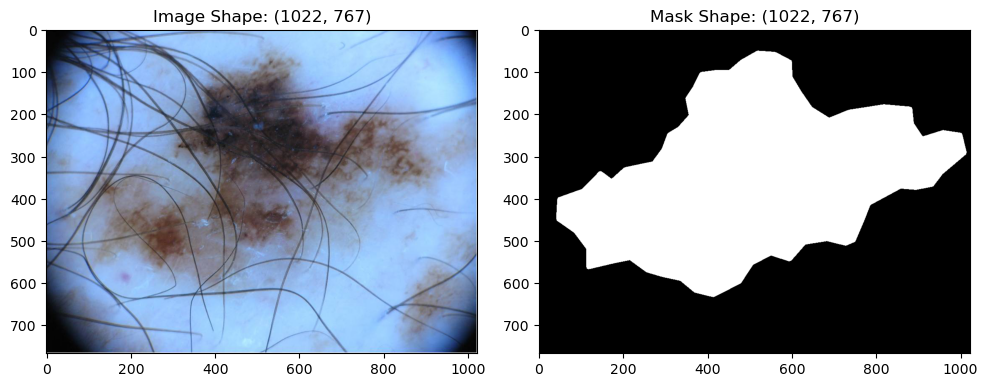

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths to your image and segmentation mask
image_path = train_image_paths[0]
mask_path = train_masks_paths[0]

# Open the image and mask using Pillow
image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the dimensions (shape) of the image and mask
image_shape = image.size  # Returns (width, height)
mask_shape = mask.size  # Returns (width, height)

# Convert the image and mask to NumPy arrays for visualization
image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap="gray")  # Assuming the mask is grayscale
plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()

In [5]:
class ISICDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = Image.open(image_path)
        mask = Image.open(mask_path)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
            mask = torch.unsqueeze(mask, 0)
            # mask = mask.float()

        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.Rotate(limit=25, p=0.1),
        A.HorizontalFlip(p=0.3),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),
        ToTensorV2(),
    ]
)

In [7]:
train_data = ISICDataset(
    train_image_paths, train_masks_paths, transform=train_transform
)
val_data  = ISICDataset(val_image_paths, val_masks_paths, transform=test_transform)
test_data  = ISICDataset(test_image_paths, test_masks_paths, transform=test_transform)

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

In [13]:
from torchvision import models


class SimpleSegmentationNet(nn.Module):
    def __init__(self, finetune=False):
        super().__init__()
        self.feature_extractor = models.mobilenet_v2(pretrained=True).features
        if not finetune:
            for parma in self.feature_extractor.parameters():
                parma.requires_grad = False

        self.seg_mask = nn.Sequential(
            nn.ConvTranspose2d(
                1280,
                512,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),
            
            nn.Conv2d(512, 256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                256,
                128,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),

            
            nn.Conv2d(128, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=2),
            nn.ReLU(),


            nn.ConvTranspose2d(
                64,
                32,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),

            nn.Conv2d(32, 16, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=3),
            nn.ReLU(),


            nn.ConvTranspose2d(
                16,
                1,
                kernel_size=2,
                stride=2,
                # output_padding=2
            ),
            nn.Sigmoid(),
            
            # nn.Conv2d(512, 256, kernel_size=2, padding=1),
            # nn.ReLU(),
            # nn.Conv2d(256, 256, kernel_size=2, padding=1),
            # nn.ReLU(),

            # nn.ConvTranspose2d(
            #     64,
            #     1,
            #     kernel_size=2,
            #     stride=2,
            # ),
            # nn.ReLU(),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        seg_mask = self.seg_mask(x)
        return seg_mask

In [14]:
from torchmetrics import JaccardIndex
from torchmetrics.functional import dice

In [16]:
model = SimpleSegmentationNet(finetune=False)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=5,
    verbose=True,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    label_idx=-1,
)
evaluation_test, test_preds, _, test_labels = evaluate(
    model,
    test_loader,
    criterion,
    device,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    return_preds=True,
    label_idx=-1,
)

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_7588\1453601988.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct[eval_metric_name] += torch.tensor(
100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


epoch: 0, train: {'loss': 0.6130365120040046, 'RMSE': 0.4560601830482483, 'dice': 0.033227318204525444, 'BinaryJaccardIndex': 0.019172013437168466}, valid: {'RMSE': 0.3897704780101776, 'dice': 0.0, 'BinaryJaccardIndex': 0.0, 'loss': 0.46355700492858887}


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


epoch: 1, train: {'loss': 0.4701876355542077, 'RMSE': 0.395711080233256, 'dice': 0.0, 'BinaryJaccardIndex': 0.0}, valid: {'RMSE': 0.37182557582855225, 'dice': 0.0, 'BinaryJaccardIndex': 0.0, 'loss': 0.4163106381893158}


100%|██████████| 23/23 [00:34<00:00,  1.51s/it]


epoch: 2, train: {'loss': 0.4353861371676127, 'RMSE': 0.3803718109925588, 'dice': 0.0, 'BinaryJaccardIndex': 0.0}, valid: {'RMSE': 0.3605654537677765, 'dice': 0.0, 'BinaryJaccardIndex': 0.0, 'loss': 0.4133802354335785}


100%|██████████| 23/23 [00:34<00:00,  1.49s/it]


epoch: 3, train: {'loss': 0.4061429977416992, 'RMSE': 0.36764285233285693, 'dice': 0.3715936495198144, 'BinaryJaccardIndex': 0.28117496305041845}, valid: {'RMSE': 0.3617645502090454, 'dice': 0.5958778858184814, 'BinaryJaccardIndex': 0.42452940344810486, 'loss': 0.4227176010608673}


100%|██████████| 23/23 [00:34<00:00,  1.50s/it]


epoch: 4, train: {'loss': 0.43025858799616495, 'RMSE': 0.3741653045018514, 'dice': 0.6727448198530409, 'BinaryJaccardIndex': 0.5082334068086413}, valid: {'RMSE': 0.3570452928543091, 'dice': 0.68051677942276, 'BinaryJaccardIndex': 0.5159388184547424, 'loss': 0.38822436332702637}


In [ ]:
# model = SimpleSegmentationNet(finetune=False)

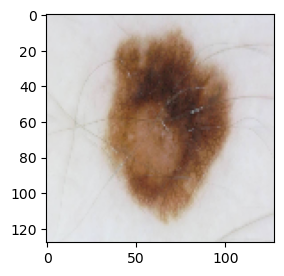

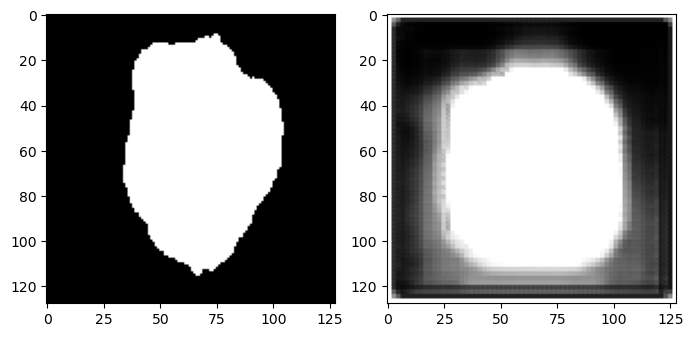

In [17]:
img, mask = next(iter(test_loader))
output = model(img.cuda())
output = output.detach().cpu().numpy()
# output = output.squeeze()
# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(img[0].permute(1,2,0))
# plt.title(f"Image Shape: {image_shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 2)
plt.imshow(mask[0].squeeze(),cmap="gray")
# Plot the mask
plt.subplot(1, 3, 3)
plt.imshow(output[0].squeeze(), cmap="gray")  # Assuming the mask is grayscale
# plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()